In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, precision_score, recall_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from IPython.display import Image
import pydotplus

In [2]:
pd.set_option('display.max_columns', None)

In this notebook, I apply classical machine learning models to predict blight from the basic features given in the data. The file 'data_more.csv' contains parcels and for each parcel the following attributes:

* crime_count: the number of crime incidents associated with the parcel,
* complaint_count: the number of 311 complaints associated with the parcel,
* violation_count: the number of blight violations associated with the parcel,
* condition: good/fair/poor/suggest demolition
* fire: yes/no
* improved: yes/no
* maintained: yes/no
* needs_boarding: yes/no
* occupancy: occupied/unoccupied/maybe
* structure: yes/no
* units: number of units the building contains (0, 1, 2-3, 4+)
* use: residential/industrial/...
* state: blighted/not_blighted -- this is what we're trying to predict

In [3]:
data = pd.read_csv('data_more.csv', header=0)

In [4]:
# make binary (numeric) labels, 0 for blighted, 1 for not_blighted
data['bin_state'] = [0 if x == 'blighted' else 1 for x in data['state']]

In [5]:
data.head()

,parcel_name,dumping,condition,fire,improved,maintained,needs_boarding,occupancy,structure,units,use,complaint_count,crime_count,violation_count,state,bin_state
0,2030 VINEWOOD,no,suggest demolition,yes,NaN,NaN,yes,unoccupied,yes,1 unit,residential,0,0,0,blighted,0
1,2034 VINEWOOD,no,suggest demolition,yes,NaN,NaN,yes,unoccupied,yes,1 unit,residential,0,0,7,blighted,0
2,3605 ROOSEVELT,yes,suggest demolition,yes,NaN,NaN,yes,unoccupied,yes,0 units,residential,0,0,0,blighted,0
3,1203 W GRAND BLVD,no,suggest demolition,no,NaN,NaN,yes,unoccupied,yes,2-3 units,residential,0,0,0,blighted,0
4,5616 VINEWOOD,no,suggest demolition,yes,NaN,NaN,yes,unoccupied,yes,1 unit,residential,0,0,0,blighted,0


## Using only violation_count

First, I'll try a "trivial" model using only the violation_count feature, which is the number of blight violations associated with the parcel. I'll use a decision tree, since that performs as well (or better) than other models and is easier to visualize and interpret.

In [9]:
X = data[['violation_count']]
y = data['bin_state']

In [22]:
model = DecisionTreeClassifier(max_depth=1, random_state=42)

In [23]:
cross_val_score(model, X, y, cv=5, n_jobs=-1)

array([ 0.59586149,  0.60557432,  0.62510566,  0.62764159,  0.63567202])

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [31]:
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [32]:
y_pred = model.predict(X_test)

In [33]:
accuracy_score(y_test, y_pred)

0.61449091677228562

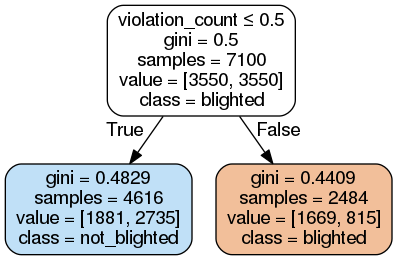

In [34]:
dot_data = export_graphviz(model, out_file=None, rotate=False, feature_names=['violation_count'], class_names=['blighted', 'not_blighted'], filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

How is it that violation_count alone performs a little better than the three counts together (violation_count, complaint_count, crime_count)? It must be the different train/test split based on the 3 columns versus just the 1 column. I think it is close enough that they are basically the same. So adding crime_count and complaint_count (below) doesn't help any.

## Using only course data

In this section I'll try to predict blight on the basis of the data from the course alone, i.e. the crime_count, complaint_count, and violation_count. I'll try a decision tree, a support-vector classifier, a perceptron, and an ensemble of extra-trees. The decision tree alone basically performs as well as anything else and has the advantage it can be easily visualized.

In [6]:
base_cols = ['crime_count', 'complaint_count', 'violation_count']

In [7]:
X = data[base_cols]
y = data['bin_state']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Decision Tree

In [38]:
dtc1 = DecisionTreeClassifier(max_depth=1, random_state=42)

In [39]:
dtc1.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [40]:
dtc1_pred = dtc1.predict(X_test)

In [41]:
accuracy_score(y_test, dtc1_pred)

0.60794254330376007

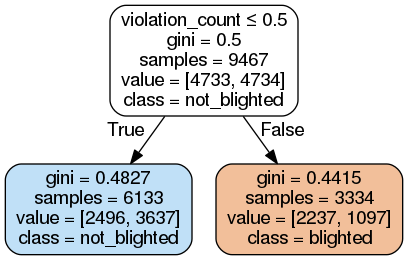

In [42]:
dot_data = export_graphviz(dtc1, out_file=None, rotate=False, feature_names=base_cols, class_names=['blighted', 'not_blighted'], filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [9]:
k = 3

In [10]:
dtck = DecisionTreeClassifier(max_depth=k, random_state=42)

In [11]:
dtck.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [12]:
dtck_pred = dtck.predict(X_test)

In [13]:
accuracy_score(y_test, dtck_pred)

0.60836501901140683

In [15]:
precision_score(y_test, dtck_pred)

0.58355091383812008

In [16]:
recall_score(y_test, dtck_pred)

0.75570583262890956

In [17]:
f1_score(y_test, dtck_pred)

0.65856353591160222

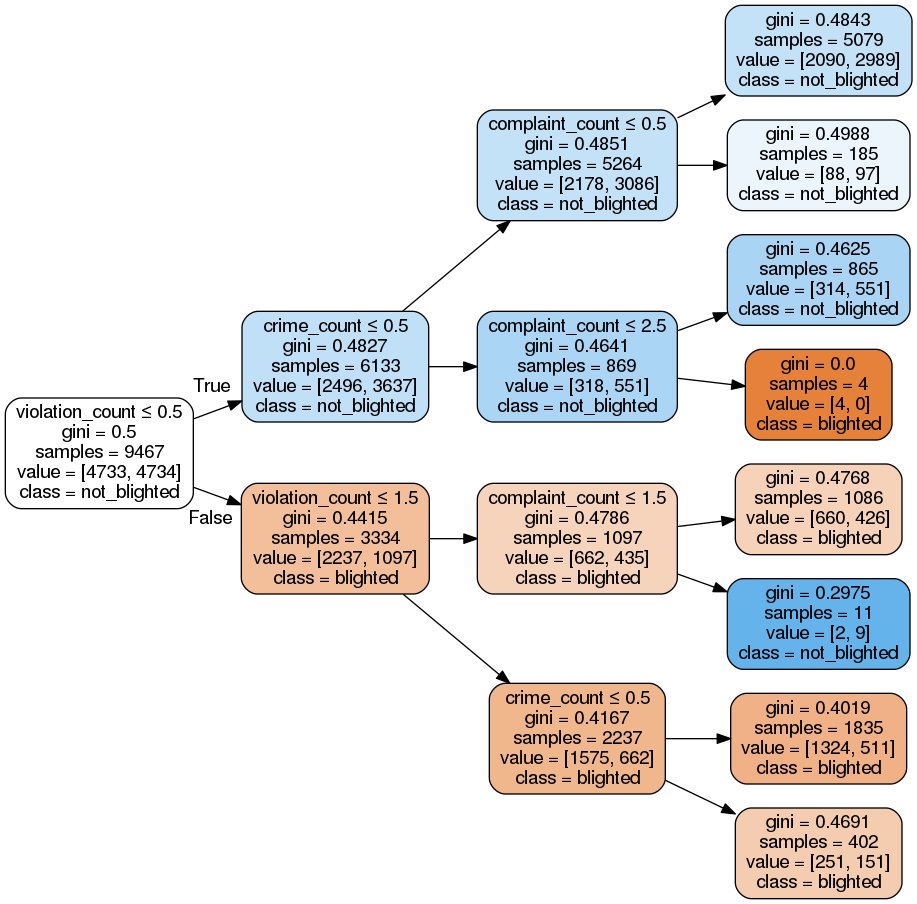

In [14]:
dot_data = export_graphviz(dtck, out_file=None, rotate=True, feature_names=base_cols, class_names=['blighted', 'not_blighted'], filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [59]:
dt = DecisionTreeClassifier(max_depth=3, random_state=42)

In [60]:
j_test = []
j_train = []
for i in range(1, len(X_train)):
    dt.fit(X_train[0:i], y_train[0:i])
    p_test = dt.predict(X_test)
    p_train = dt.predict(X_train)
    j_test.append(mean_squared_error(y_test, p_test))
    j_train.append(mean_squared_error(y_train, p_train))

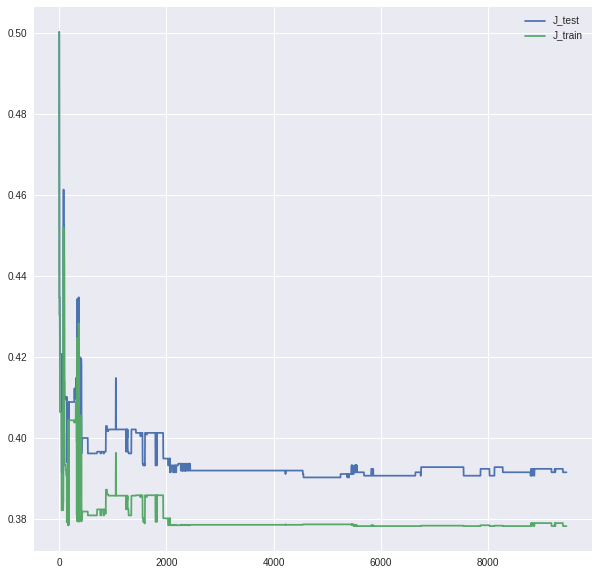

In [62]:
plt.figure(figsize=(10,10))
plt.plot(j_test, label='J_test')
plt.plot(j_train, label='J_train')
plt.legend()
plt.show()

The training graph above is pretty clear: more data won't help. What we really need is more features to distinguish blighted parcels from not_blighted ones. First I'll try a couple of other models.

### Support Vector Classifier

In [63]:
svm_model = SVC(C=1.0, kernel='rbf', probability=False, verbose=False, random_state=42)

In [64]:
svm_model.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [65]:
svm_pred = svm_model.predict(X_test)

In [66]:
accuracy_score(y_test, svm_pred)

0.60794254330376007

### Multi-Layer Perceptron Classifier

In [67]:
mlp_model = MLPClassifier(hidden_layer_sizes=(5,5), activation='relu', solver='adam', alpha=0.0001, random_state=42)

In [68]:
mlp_model.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 5), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [69]:
mlp_pred = mlp_model.predict(X_test)

In [70]:
accuracy_score(y_test, mlp_pred)

0.49978876214617657

### Extra-Trees Ensemble Classification

In [79]:
xtc = ExtraTreesClassifier(max_depth=10, n_jobs=-1, random_state=42)

In [80]:
xtc.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=10, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [81]:
xtc_pred = xtc.predict(X_test)

In [82]:
accuracy_score(y_test, xtc_pred)

0.60836501901140683

At this point, I played with the settings on these models, but none did significantly better than a single decision tree. I decided to stick with the decision tree since it is easy to visualize and interpret.

## Using Course Features and MCM Features Together

In [18]:
dummy_cols = ['dumping', 'condition', 'improved', 'fire', 'maintained', 'needs_boarding', 'occupancy', 'structure', 'units', 'use']

In [19]:
newdata = pd.get_dummies(data, columns=dummy_cols)

In [20]:
newdata.head()

,parcel_name,complaint_count,crime_count,violation_count,state,bin_state,dumping_no,dumping_yes,condition_fair,condition_good,condition_poor,condition_suggest demolition,improved_improved,improved_unimproved,fire_no,fire_yes,maintained_no,maintained_yes,needs_boarding_no,needs_boarding_yes,occupancy_maybe,occupancy_occupied,occupancy_unoccupied,structure_no,structure_yes,units_0 units,units_1 unit,units_2-3 units,units_4+ units,use_commercial,use_industrial,use_institutional,use_mixed,use_private,use_public,use_residential,use_unknown
0,2030 VINEWOOD,0,0,0,blighted,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0
1,2034 VINEWOOD,0,0,7,blighted,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0
2,3605 ROOSEVELT,0,0,0,blighted,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0
3,1203 W GRAND BLVD,0,0,0,blighted,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0
4,5616 VINEWOOD,0,0,0,blighted,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0


In [21]:
model_cols = [c for c in newdata.columns if not c in ['parcel_name', 'state', 'bin_state', 'condition_suggest demolition']]

In [22]:
X = newdata[model_cols]
y = newdata['bin_state']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [24]:
model = DecisionTreeClassifier(max_depth=3, random_state=42)

In [25]:
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [26]:
y_pred = model.predict(X_test)

In [27]:
accuracy_score(y_test, y_pred)

0.87917194761301221

In [28]:
precision_score(y_test, y_pred)

0.84794414274631502

In [29]:
recall_score(y_test, y_pred)

0.92392223161453935

In [30]:
f1_score(y_test, y_pred)

0.88430420711974111

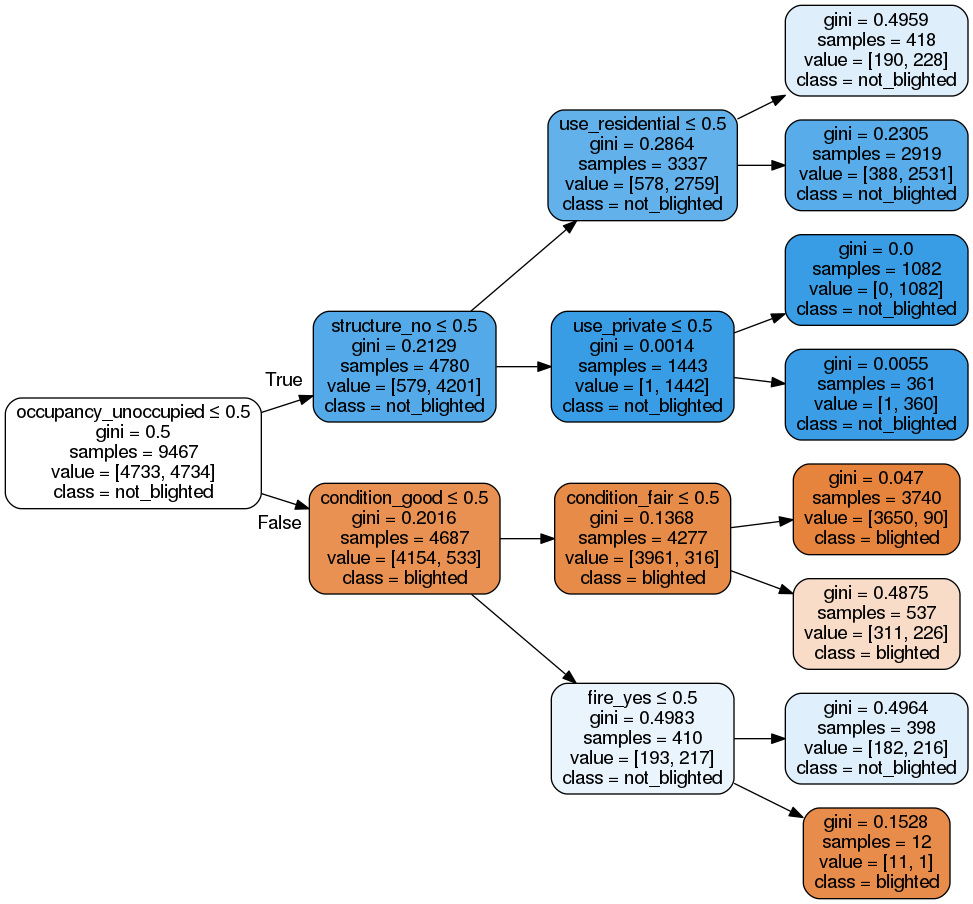

In [113]:
dot_data = export_graphviz(model, out_file=None, rotate=True, feature_names=model_cols, class_names=['blighted', 'not_blighted'], filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())